In [1]:
import pandas as pd
from pymongo import MongoClient, GEO2D
import pymongo
import json
import datetime
from bson.son import SON
import folium 
from math import *
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly.graph_objs import *


In [2]:
df_20150817 = pd.read_csv('/home/kathrin/Doctorado/bus_rio/Datos_Omnibus/morte_motoqueiro_20150817/20150817.txt', delimiter = ('\t'))

In [3]:
df_20150817_line_317 = df_20150817[(df_20150817['line']=='317')]

In [4]:
#Estableciendo la conexion con la base de datos morte_motoquiro en MongoDB
db = MongoClient().morte_motoquiro_event

In [5]:
onibus317_shapes = pd.read_csv('/home/kathrin/Doctorado/bus_rio/Datos_Omnibus/Onibus/Shapes/gtfs_linha317-shapes.csv')

In [6]:
df_initial_point = onibus317_shapes[(onibus317_shapes['sequencia']==0)]
df_initial_point

,linha,descricao,agencia,sequencia,shape_id,latitude,longitude
0,317,317-CENTRAL X ALVORADA (VIA TUNEL SANTA BARBAR...,Fetranspor,0,17424059,-22.9049,-43.1917
1041,317,317-CENTRAL X ALVORADA (VIA TUNEL SANTA BARBAR...,Fetranspor,0,17589381,-23.0012,-43.3649


In [7]:
#Punto inicial del omnibus 317 Central do Brasil
initial_point = (-22.9049,-43.1917)
#Punto inicial del omnibus invertido
inverted_initial_point = (-43.1917, -22.9049)
#Punto final del omnibus 317 Centro
final_point = (-23.0012, -43.3649)
#Punto final del omnibus invertido
inverted_final_point = (-43.3649, -23.0012)

In [8]:
"""Funciones para renderizar el mapa en el html"""
from IPython.display import HTML
 
def inline_map(map):
    """
    Embeds the HTML source of the map directly into the IPython notebook.
    
    This method will not work if the map depends on any files (json data). Also this uses
    the HTML5 srcdoc attribute, which may not be supported in all browsers.
    """
    map._build_map()
    return HTML('<iframe srcdoc="{srcdoc}" style="width: 100%; height: 510px; border: none"></iframe>'.format(srcdoc=map.HTML.replace('"', '&quot;')))
 
def embed_map(map, path="map.html"):
    """
    Embeds a linked iframe to the map into the IPython notebook.
    
    Note: this method will not capture the source of the map into the notebook.
    This method should work for all maps (as long as they use relative urls).
    """
    map.create_map(path=path)
    return HTML('<iframe src="files/{path}" style="width: 100%; height: 510px; border: none"></iframe>'.format(path=path))

In [9]:
fmap317=folium.Map(location=[-22.923714, -43.258999], zoom_start=11)
locations317 = []
for row in onibus317_shapes.iterrows():
    #The 'latitude' and 'longitude' names correspond to column names in the original cceats dataframe
    locations317.insert(len(locations317), [ row[1]['latitude'], row[1]['longitude'] ])
    
#Pintando Circulos de radio de 50m alrededor de los puntos incial y final 
fmap317.simple_marker(initial_point, popup='Central')
fmap317.simple_marker(final_point, popup='Alborada')
fmap317.simple_marker((-22.992551 , -43.249098), popup='Morte Motoqueiro')

#Punto inicial
fmap317.circle_marker(location=final_point, radius=50,line_color='green',
                 fill_color='#3186cc', fill_opacity=0.2)

#Punto inicial
fmap317.circle_marker(location=initial_point, radius=50,line_color='red',
                 fill_color='#3186cc', fill_opacity=0.2)

fmap317.line(locations317)
embed_map(fmap317)

In [10]:
#esto es para graficar todos los puntos de todos los omnibus 317 que cirsularon ese dia
for row in df_20150817_line_317.iterrows():
    #The 'latitude' and 'longitude' names correspond to column names in the original cceats dataframe
    latlon = [ row[1]['latitude'], row[1]['longitude'] ]
    fmap317.polygon_marker( latlon, fill_color='green', num_sides=4, radius=6)
    

embed_map(fmap317)

In [11]:
#Function to compute the bus_ids circulating during a day  
bus_id_20150817_317 = db.dados20150817_line_317.distinct("bus_id")
bus_id_20150817_317

[u'C41405', u'C41406', u'C41401', u'C41408']

In [12]:
#meter en una lista todos los bus_id
def get_busId_list(busId_list):
    array_busId = []
    for bus in busId_list:
        strbus = str(bus)
        array_busId.insert(len(array_busId), strbus)
    return array_busId

In [13]:
array_busId = get_busId_list(bus_id_20150817_317)
array_busId

['C41405', 'C41406', 'C41401', 'C41408']

In [26]:
#funcion que dado un el bus_id de un omnibus y un punto inicial/final devuelve los puntos mas cercanos a ese punto. 
# A esa función se le debería pasar también la BD, pero ahora no se va a hacer asi
def near_points_to_origin (bus_id, inverted_origin_point):
    near_initial_points_array = []
    #la funcion $within recibe las coordenadas en orden inverso (primero longitud y después latitud)
    for row in db.dados20150727_line_317.find({"latlon": {"$within": {"$center": [inverted_origin_point, 0.0035499543]}}, "bus_id": bus_id}).sort("timestamp",pymongo.DESCENDING):
    #for row in db.dados20150817_line_317.find({"latlon": {"$within": {"$center": [inverted_origin_point, 0.0115499543]}}, "bus_id": bus_id}).sort("timestamp",pymongo.DESCENDING):   
        near_initial_points_array.insert(0, [row[u'timestamp'], row[u'latitude'], row[u'longitude'], row[u'speed']])
    #convert the array in panda dataframe 
    sorted_near_initial_points = pd.DataFrame(near_initial_points_array, columns=['timestamp', 'latitude', 'longitude', 'speed'])
    return sorted_near_initial_points

In [15]:
def bus_departure_hour (initial_points_timestamp_list):
    list_departure_hours = []
    i = 0
    if len(initial_points_timestamp_list) >1:
        for i in range(0, len(initial_points_timestamp_list)-1):
            resto = datetime.datetime.strptime(initial_points_timestamp_list[i+1], "%d-%m-%Y %H:%M:%S")-datetime.datetime.strptime(initial_points_timestamp_list[i], "%d-%m-%Y %H:%M:%S")
            resto_total = resto.total_seconds()/60
            #si la diferencia entre los timestamp del omnibus en el putno supera los 40 minutos es q dio un viaje y regreso, sino lo supera es que se mantuvo ese tiempo esperando en el punto
            if (resto_total > 40):
                 list_departure_hours.insert(len( list_departure_hours),datetime.datetime.strptime(initial_points_timestamp_list[i], "%d-%m-%Y %H:%M:%S"))
        #siempre es necesario insertar el ultimo valor de la lista de "initial_points_timestamp" en la lista de  list_departure_hours 
        list_departure_hours.insert(len( list_departure_hours),datetime.datetime.strptime(initial_points_timestamp_list[i+1], "%d-%m-%Y %H:%M:%S"))
    elif len(initial_points_timestamp_list) == 1:
        list_departure_hours.insert(len( list_departure_hours),datetime.datetime.strptime(initial_points_timestamp_list[0], "%d-%m-%Y %H:%M:%S"))
    else:
        list_departure_hours = []
    return list_departure_hours

In [16]:
#Funcion que retorna el arreglo con las horas de llegada del omnibus al punto inicial/final del trayecto
def bus_arrive_hour (initial_points_timestamp_list):
    list_arrive_hours = []
    #siempre es necesario insertar el ultimo valor de la lista de "initial_points_timestamp" en la lista de leblon_departure_hours 
    if len(initial_points_timestamp_list) >1:
        list_arrive_hours.insert(len(list_arrive_hours),datetime.datetime.strptime(initial_points_timestamp_list[0], "%d-%m-%Y %H:%M:%S"))
        for i in range(0,  len(initial_points_timestamp_list)-1):
            resto = datetime.datetime.strptime(initial_points_timestamp_list[i+1], "%d-%m-%Y %H:%M:%S")-datetime.datetime.strptime(initial_points_timestamp_list[i], "%d-%m-%Y %H:%M:%S")
            resto_total = resto.total_seconds()/60
            if (resto_total > 40):
                list_arrive_hours.insert(len(list_arrive_hours),datetime.datetime.strptime(initial_points_timestamp_list[i+1], "%d-%m-%Y %H:%M:%S"))
    elif (len(initial_points_timestamp_list) == 1):
        list_arrive_hours.insert(len(list_arrive_hours),datetime.datetime.strptime(initial_points_timestamp_list[0], "%d-%m-%Y %H:%M:%S"))
    else:
        list_arrive_hours = []        
    return list_arrive_hours

In [17]:
#Para convertir de formato timedelta para horas y minutos
def days_hours_minutes(travel_time):
    hours = travel_time.seconds//3600 
    minutes = (travel_time.seconds//60)%60
    #print '%d hours, %d minutes' % (hours,minutes)
    if minutes < 10:
        minutes = str(0)+str(minutes)
    return str(hours) + ":"+ str(minutes)

In [18]:
#Funcion que crea la tabla de viajes con los tiempos de viaje
def create_travel_table (name_A, arrive_array_A, departure_array_A, name_B, arrive_array_B, departure_array_B, bus_Id, bus_line):
    
    my_time_table = []   
    num_travel = 0    
    i = 0 #Cursor para moverme por el departure_array_A(arreglo q contiene las horas de salida del punto incial)   
    j = 0 #Cursor para moverme por el departure_array_B (arreglo q contiene las horas de salida del punto final)
   
    while (i<len(departure_array_A) and j< len(departure_array_B)):
        if (departure_array_A[i] < departure_array_B[j]):
            if(i+1 == len(departure_array_A)):
                direction = name_A + "_to_" + name_B
                departure_hour = departure_array_A[i]
                i = i +1
                arrive_hour = arrive_array_B[j]
                num_travel = num_travel +1
                travel_time = days_hours_minutes(arrive_hour - departure_hour)          
                my_time_table.insert(len(my_time_table), [bus_line, bus_Id, direction, departure_hour,arrive_hour, travel_time])
         
            elif ((i+1 < len(departure_array_A)) and (departure_array_B[j] < departure_array_A[i+1])):
                direction = name_A + "_to_" + name_B
                departure_hour = departure_array_A[i]
                i = i +1
                arrive_hour = arrive_array_B[j]
                num_travel = num_travel +1
                travel_time = days_hours_minutes(arrive_hour - departure_hour)          
                my_time_table.insert(len(my_time_table), [bus_line, bus_Id, direction, departure_hour,arrive_hour, travel_time])
            else: 
                i = i +1
            
        elif(departure_array_B[j] < departure_array_A[i]):
            if (j+1 == len(departure_array_B)):
                direction = name_B + "_to_" + name_A
                departure_hour = departure_array_B[j]
                j = j +1
                arrive_hour = arrive_array_A[i]
                num_travel = num_travel +1
                travel_time = days_hours_minutes(arrive_hour - departure_hour)          
                my_time_table.insert(len(my_time_table), [bus_line, bus_Id, direction, departure_hour,arrive_hour, travel_time])
            
            elif ((j+1 < len(departure_array_B)) and (departure_array_A[i] < departure_array_B[j+1])):
                direction = name_B + "_to_" + name_A
                departure_hour = departure_array_B[j]
                j = j +1
                arrive_hour = arrive_array_A[i]
                num_travel = num_travel +1
                travel_time = days_hours_minutes(arrive_hour - departure_hour)          
                my_time_table.insert(len(my_time_table), [bus_line, bus_Id, direction, departure_hour,arrive_hour, travel_time])
            else:
                j = j +1                
            
    #Construir el dataframe pasandole el array con todos los datos de los viajes   
    mydf = pd.DataFrame(my_time_table, columns=['Line', 'Bus_Id','Direction','Departure_Hour', 'Arrive_Hour', 'Travel_Time'])       
    return mydf  

In [19]:
#Funcion que crea la tabla de tiempo de viaje para cada bus_id de los que transitaron el el dia
def all_travel_table (line, punto_ini_coord_invertidas, name_punto_inicio, punto_fin_coord_invertidas, name_punto_final, array_busId):
    new_df = pd.DataFrame(columns=['Line', 'Bus_Id','Direction','Departure_Hour', 'Arrive_Hour', 'Travel_Time'])  
    for busId in array_busId:
        sorted_near_initial_points1 = near_points_to_origin(busId, punto_ini_coord_invertidas)
        sorted_near_final_points1 = near_points_to_origin(busId, punto_fin_coord_invertidas)
        initial_points_timestamp1 = sorted_near_initial_points1 ['timestamp']
        final_points_timestamp1 = sorted_near_final_points1 ['timestamp']
        #chequear si la lista initial_points_timestamp es diferente de vacio
        if len(initial_points_timestamp1) and len(final_points_timestamp1):
            vilaIsabel_departure_hours1 = bus_departure_hour(initial_points_timestamp1)
            first_point_departure_hour = bus_departure_hour (initial_points_timestamp1)
            last_point_departure_hour = bus_departure_hour (final_points_timestamp1)
            first_point_arrive_hour = bus_arrive_hour(initial_points_timestamp1)
            last_point_arrive_hour = bus_arrive_hour(final_points_timestamp1)
            my_time_table = create_travel_table(name_punto_inicio, first_point_arrive_hour, first_point_departure_hour, name_punto_final, last_point_arrive_hour, last_point_departure_hour, busId, line)
            new_df = new_df.append(my_time_table, ignore_index=True)
    return new_df

In [20]:
travel_table_20150817 = all_travel_table ('317', inverted_initial_point, 'Central', inverted_final_point, 'Alborada', array_busId)
travel_table_20150817

,Line,Bus_Id,Direction,Departure_Hour,Arrive_Hour,Travel_Time
0,317,C41405,Alborada_to_Central,2015-08-17 08:49:48,2015-08-17 10:45:56,1:56
1,317,C41405,Central_to_Alborada,2015-08-17 13:12:03,2015-08-17 14:20:17,1:08
2,317,C41406,Central_to_Alborada,2015-08-17 07:59:03,2015-08-17 09:27:51,1:28
3,317,C41406,Alborada_to_Central,2015-08-17 09:52:02,2015-08-17 11:15:19,1:23
4,317,C41406,Central_to_Alborada,2015-08-17 14:52:22,2015-08-17 16:37:11,1:44
5,317,C41406,Alborada_to_Central,2015-08-17 17:16:56,2015-08-17 19:02:22,1:45
6,317,C41406,Central_to_Alborada,2015-08-17 19:15:48,2015-08-17 20:59:13,1:43
7,317,C41406,Alborada_to_Central,2015-08-17 21:17:56,2015-08-17 22:27:21,1:09
8,317,C41401,Central_to_Alborada,2015-08-17 08:56:56,2015-08-17 10:30:07,1:33
9,317,C41401,Alborada_to_Central,2015-08-17 11:10:03,2015-08-17 12:49:06,1:39


In [27]:
#dados relacionados con el mismo omnibus 317 pero el dia 27/07/2015 
df_20150727 = pd.read_csv('/home/kathrin/Doctorado/bus_rio/Datos_Omnibus/morte_motoqueiro_20150817/20150727.txt', delimiter = ('\t'))
bus_id_20150727_317 = db.dados20150727_line_317.distinct("bus_id")

array_busId_20150727 = get_busId_list(bus_id_20150727_317)
travel_table_20150727 = all_travel_table ('317', inverted_initial_point, 'Alborada', inverted_final_point, 'Central', array_busId_20150727)
travel_table_20150727


,Line,Bus_Id,Direction,Departure_Hour,Arrive_Hour,Travel_Time
0,317,C41102,Alborada_to_Central,2015-07-27 04:25:57,2015-07-27 05:12:59,0:47
1,317,C41102,Central_to_Alborada,2015-07-27 05:22:38,2015-07-27 06:42:34,1:19
2,317,C41102,Alborada_to_Central,2015-07-27 06:50:44,2015-07-27 08:30:42,1:39
3,317,C41102,Central_to_Alborada,2015-07-27 08:36:32,2015-07-27 10:14:53,1:38
4,317,C41237,Alborada_to_Central,2015-07-27 08:06:36,2015-07-27 09:48:59,1:42
5,317,C41237,Central_to_Alborada,2015-07-27 10:01:49,2015-07-27 11:35:05,1:33
6,317,C41237,Alborada_to_Central,2015-07-27 12:07:50,2015-07-27 13:21:53,1:14
7,317,C41237,Central_to_Alborada,2015-07-27 13:38:48,2015-07-27 14:51:58,1:13
8,317,C41237,Alborada_to_Central,2015-07-27 15:10:03,2015-07-27 16:38:51,1:28
9,317,C41093,Alborada_to_Central,2015-07-27 04:51:50,2015-07-27 05:41:40,0:49


In [28]:
df_20150817_line_317_C41405 = df_20150817_line_317[(df_20150817_line_317['bus_id']=='C41405')]
#para seleccionar solo algunas columnas del dataframe, en este caso la columna 1(timestamp), la 4(latitude) y la 5(longitude)
important_columns_C41405 = df_20150817_line_317_C41405 .iloc[:,[0,3,4]]
vector_C41405 = important_columns_C41405.values.tolist()

In [22]:
#Funcion para calcular la distancia entre 2 puntos, teniendo en cuenta el radio de la tierra
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return (c * r)*1000 # return the distance in m

In [23]:
"""
funcion que dado un vector de lat, long y un punto A(lat,long), me devuelve un vector con
la distancia de cada par al punto A
 """
def vector_distancia(vector, point):
    vector_distance = []
    lat2 = point[0]
    long2 = point[1]
    for item in vector:
        lat1 = item[1]
        long1 = item[2]
        distance = haversine(long2, lat2, long1, lat1)
        latlon = (item[1], item[2])
        vector_distance.insert(len(vector_distance), [item[0],latlon, distance])
    df_vector_distance = pd.DataFrame(vector_distance, columns=['timestamp', 'latlon', 'distance'])
    return df_vector_distance   

In [24]:
vector_dist_to_ini_point_C41405 = vector_distancia(vector_C41405, initial_point)
sorted_vector_dist_to_ini_point_C41405 = vector_dist_to_ini_point_C41405.sort(["timestamp"])

vector_dist_to_final_point_C41405  = vector_distancia(vector_C41405, final_point)
sorted_vector_dist_to_final_point_C41405 = vector_dist_to_final_point_C41405.sort(["timestamp"])

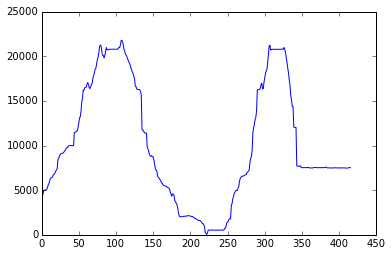

In [25]:
#ploteando el vector distancia entre cada uno de los puntos del recorrido y el punto inicial Barra
%matplotlib inline
plt.plot(sorted_vector_dist_to_ini_point_C41405['distance'], color = 'b')
plt.show()

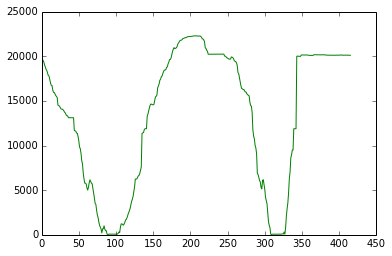

In [38]:
#ploteando el vector distancia entre cada uno de los puntos del recorrido y el punto final Central
%matplotlib inline
plt.plot(sorted_vector_dist_to_final_point_C41405['distance'], color = 'g')

plt.show()

In [29]:
#hacer una grafica interactiva con la libreria de python (plotly.plotly). Se instala por consola asi: sudo pip install plotly
#distancia del punto final (central)

trace_C41405 = Scatter(x = sorted_vector_dist_to_ini_point_C41405['timestamp'], y = sorted_vector_dist_to_ini_point_C41405['distance'])
data = Data([trace_C41405])
py.iplot(data, filename='pandas-time-series')

In [51]:
#hacer una grafica interactiva con la libreria de python (plotly.plotly). Se instala por consola asi: sudo pip install plotly
#distancia del punto final (central)

trace_C41405 = Scatter(x = sorted_vector_dist_to_final_point_C41405['timestamp'], y = sorted_vector_dist_to_final_point_C41405['distance'])
data = Data([trace_C41405])
py.iplot(data, filename='pandas-time-series')

In [64]:
sorted_near_initial_points_C41405 = near_points_to_origin ('C41405', inverted_initial_point)
sorted_near_final_points_C41405 = near_points_to_origin ('C41405', inverted_final_point)

initial_points_timestamp = sorted_near_initial_points_C41405['timestamp']
final_points_timestamp = sorted_near_final_points_C41405['timestamp']

initial_departure_hours = bus_departure_hour(initial_points_timestamp)
final_departure_hours = bus_departure_hour(final_points_timestamp)

arrive_hour_to_initialpoint = bus_arrive_hour(initial_points_timestamp)
arrive_hour_to_finalpoint = bus_arrive_hour(final_points_timestamp)



In [54]:
travel_table_C41405 = create_travel_table("Central", arrive_hour_to_initialpoint, initial_departure_hours, "Alborada", arrive_hour_to_finalpoint, final_departure_hours, 'C41405', '317' )
travel_table_C41405

,Line,Bus_Id,Direction,Departure_Hour,Arrive_Hour,Travel_Time
0,317,C41405,Alborada_to_Central,2015-08-17 08:49:48,2015-08-17 10:45:56,1:56
1,317,C41405,Central_to_Alborada,2015-08-17 13:12:03,2015-08-17 14:20:17,1:08


In [55]:
#lo mismo para el bus_id C41406
df_20150817_line_317_C41406 = df_20150817_line_317[(df_20150817_line_317['bus_id']=='C41406')]
#para seleccionar solo algunas columnas del dataframe, en este caso la columna 1(timestamp), la 4(latitude) y la 5(longitude)
important_columns_C41406 = df_20150817_line_317_C41406.iloc[:,[0,3,4]]
vector_C41406 = important_columns_C41406.values.tolist()

vector_dist_to_ini_point_C41406 = vector_distancia(vector_C41406, initial_point)
sorted_vector_dist_to_ini_point_C41406 = vector_dist_to_ini_point_C41406.sort(["timestamp"])

vector_dist_to_final_point_C41406  = vector_distancia(vector_C41406, final_point)
sorted_vector_dist_to_final_point_C41406 = vector_dist_to_final_point_C41406.sort(["timestamp"])

In [56]:
#hacer una grafica interactiva con la libreria de python (plotly.plotly). Se instala por consola asi: sudo pip install plotly
#distancia del punto final (central)

trace_C41406 = Scatter(x = sorted_vector_dist_to_ini_point_C41406['timestamp'], y = sorted_vector_dist_to_ini_point_C41406['distance'])
data = Data([trace_C41406])
py.iplot(data, filename='pandas-time-series')

In [58]:
sorted_near_initial_points_C41406 = near_points_to_origin ('C41406', inverted_initial_point)
sorted_near_final_points_C41406 = near_points_to_origin ('C41406', inverted_final_point)

initial_points_timestamp_C41406 = sorted_near_initial_points_C41406['timestamp']
final_points_timestamp_C41406 = sorted_near_final_points_C41406['timestamp']

initial_departure_hours_C41406 = bus_departure_hour(initial_points_timestamp_C41406)
final_departure_hours_C41406 = bus_departure_hour(final_points_timestamp_C41406)

arrive_hour_to_initialpoint_C41406 = bus_arrive_hour(initial_points_timestamp_C41406)
arrive_hour_to_finalpoint_C41406 = bus_arrive_hour(final_points_timestamp_C41406)

travel_table_C41406 = create_travel_table("Central", arrive_hour_to_initialpoint_C41406, initial_departure_hours_C41406, "Alborada", arrive_hour_to_finalpoint_C41406, final_departure_hours_C41406, 'C41406', '317' )
travel_table_C41406

,Line,Bus_Id,Direction,Departure_Hour,Arrive_Hour,Travel_Time
0,317,C41406,Central_to_Alborada,2015-08-17 07:59:03,2015-08-17 09:27:51,1:28
1,317,C41406,Alborada_to_Central,2015-08-17 09:52:02,2015-08-17 11:15:19,1:23
2,317,C41406,Central_to_Alborada,2015-08-17 14:52:22,2015-08-17 16:37:11,1:44
3,317,C41406,Alborada_to_Central,2015-08-17 17:16:56,2015-08-17 19:02:22,1:45
4,317,C41406,Central_to_Alborada,2015-08-17 19:15:48,2015-08-17 20:59:13,1:43
5,317,C41406,Alborada_to_Central,2015-08-17 21:17:56,2015-08-17 22:27:21,1:09


In [59]:
#lo mismo para el bus_id C41408
df_20150817_line_317_C41408 = df_20150817_line_317[(df_20150817_line_317['bus_id']=='C41408')]
#para seleccionar solo algunas columnas del dataframe, en este caso la columna 1(timestamp), la 4(latitude) y la 5(longitude)
important_columns_C41408 = df_20150817_line_317_C41408.iloc[:,[0,3,4]]
vector_C41408 = important_columns_C41408.values.tolist()

vector_dist_to_ini_point_C41408 = vector_distancia(vector_C41408, initial_point)
sorted_vector_dist_to_ini_point_C41408 = vector_dist_to_ini_point_C41408.sort(["timestamp"])

vector_dist_to_final_point_C41408  = vector_distancia(vector_C41408, final_point)
sorted_vector_dist_to_final_point_C41408 = vector_dist_to_final_point_C41408.sort(["timestamp"])

In [37]:
#hacer una grafica interactiva con la libreria de python (plotly.plotly). Se instala por consola asi: sudo pip install plotly
#distancia del punto final (central)

trace_C41408 = Scatter(x = sorted_vector_dist_to_ini_point_C41408['timestamp'], y = sorted_vector_dist_to_ini_point_C41408['distance'])
data = Data([trace_C41408])
py.iplot(data, filename='pandas-time-series')

In [60]:
sorted_near_initial_points_C41408 = near_points_to_origin ('C41408', inverted_initial_point)
sorted_near_final_points_C41408 = near_points_to_origin ('C41408', inverted_final_point)

initial_points_timestamp_C41408 = sorted_near_initial_points_C41408['timestamp']
final_points_timestamp_C41408 = sorted_near_final_points_C41408['timestamp']

initial_departure_hours_C41408 = bus_departure_hour(initial_points_timestamp_C41408)
final_departure_hours_C41408 = bus_departure_hour(final_points_timestamp_C41408)

arrive_hour_to_initialpoint_C41408 = bus_arrive_hour(initial_points_timestamp_C41408)
arrive_hour_to_finalpoint_C41408 = bus_arrive_hour(final_points_timestamp_C41408)

travel_table_C41408 = create_travel_table("Central", arrive_hour_to_initialpoint_C41408, initial_departure_hours_C41408, "Alborada", arrive_hour_to_finalpoint_C41408, final_departure_hours_C41408, 'C41408', '317' )
travel_table_C41408

,Line,Bus_Id,Direction,Departure_Hour,Arrive_Hour,Travel_Time
0,317,C41408,Central_to_Alborada,2015-08-17 08:17:38,2015-08-17 09:53:20,1:35
1,317,C41408,Alborada_to_Central,2015-08-17 10:27:57,2015-08-17 11:50:11,1:22
2,317,C41408,Central_to_Alborada,2015-08-17 12:23:04,2015-08-17 13:41:06,1:18
3,317,C41408,Alborada_to_Central,2015-08-17 14:06:52,2015-08-17 15:20:53,1:14
4,317,C41408,Central_to_Alborada,2015-08-17 15:50:11,2015-08-17 17:38:19,1:48
5,317,C41408,Alborada_to_Central,2015-08-17 18:00:04,2015-08-17 19:28:48,1:28


In [61]:
#lo mismo para el bus_id C41401
df_20150817_line_317_C41401 = df_20150817_line_317[(df_20150817_line_317['bus_id']=='C41401')]
#para seleccionar solo algunas columnas del dataframe, en este caso la columna 1(timestamp), la 4(latitude) y la 5(longitude)
important_columns_C41401 = df_20150817_line_317_C41401.iloc[:,[0,3,4]]
vector_C41401 = important_columns_C41401.values.tolist()

vector_dist_to_ini_point_C41401 = vector_distancia(vector_C41401, initial_point)
sorted_vector_dist_to_ini_point_C41401 = vector_dist_to_ini_point_C41401.sort(["timestamp"])

vector_dist_to_final_point_C41401  = vector_distancia(vector_C41401, final_point)
sorted_vector_dist_to_final_point_C41401 = vector_dist_to_final_point_C41401.sort(["timestamp"])

In [39]:
#hacer una grafica interactiva con la libreria de python (plotly.plotly). Se instala por consola asi: sudo pip install plotly
#distancia del punto final (central)

trace_C41401 = Scatter(x = sorted_vector_dist_to_ini_point_C41401['timestamp'], y = sorted_vector_dist_to_ini_point_C41401['distance'])
data = Data([trace_C41401])
py.iplot(data, filename='pandas-time-series')

In [62]:
sorted_near_initial_points_C41401 = near_points_to_origin ('C41401', inverted_initial_point)
sorted_near_final_points_C41401 = near_points_to_origin ('C41401', inverted_final_point)

initial_points_timestamp_C41401 = sorted_near_initial_points_C41401['timestamp']
final_points_timestamp_C41401 = sorted_near_final_points_C41401['timestamp']

initial_departure_hours_C41401 = bus_departure_hour(initial_points_timestamp_C41401)
final_departure_hours_C41401 = bus_departure_hour(final_points_timestamp_C41401)

arrive_hour_to_initialpoint_C41401 = bus_arrive_hour(initial_points_timestamp_C41401)
arrive_hour_to_finalpoint_C41401 = bus_arrive_hour(final_points_timestamp_C41401)

travel_table_C41401 = create_travel_table("Central", arrive_hour_to_initialpoint_C41401, initial_departure_hours_C41401, "Alborada", arrive_hour_to_finalpoint_C41401, final_departure_hours_C41401, 'C41401', '317' )
travel_table_C41401

,Line,Bus_Id,Direction,Departure_Hour,Arrive_Hour,Travel_Time
0,317,C41401,Central_to_Alborada,2015-08-17 08:56:56,2015-08-17 10:30:07,1:33
1,317,C41401,Alborada_to_Central,2015-08-17 11:10:03,2015-08-17 12:49:06,1:39
2,317,C41401,Central_to_Alborada,2015-08-17 13:17:58,2015-08-17 14:43:21,1:25
3,317,C41401,Alborada_to_Central,2015-08-17 15:04:24,2015-08-17 16:22:15,1:17
4,317,C41401,Central_to_Alborada,2015-08-17 17:30:18,2015-08-17 19:32:13,2:01
5,317,C41401,Alborada_to_Central,2015-08-17 19:56:55,2015-08-17 21:10:58,1:14


In [43]:
import plotly.plotly as py
from plotly.graph_objs import *

trace0 = Scatter(
  x=[1, 2, 3, 4],
  y=[10, 15, 13, 17]
)
trace1 = Scatter(
  x=[1, 2, 3, 4],
  y=[16, 5, 11, 9]
)
data = Data([trace0, trace1])

py.iplot(data, filename = 'basic-line')

In [30]:
central_Alborada_20150727 = travel_table_20150727[(travel_table_20150727['Direction'] == 'Central_to_Alborada')]
central_Alborada_20150727_sorted = central_Alborada_20150727.sort(["Departure_Hour"])
central_Alborada_20150727_sorted


,Line,Bus_Id,Direction,Departure_Hour,Arrive_Hour,Travel_Time
1,317,C41102,Central_to_Alborada,2015-07-27 05:22:38,2015-07-27 06:42:34,1:19
3,317,C41102,Central_to_Alborada,2015-07-27 08:36:32,2015-07-27 10:14:53,1:38
10,317,C41413,Central_to_Alborada,2015-07-27 09:16:39,2015-07-27 14:27:58,5:11
5,317,C41237,Central_to_Alborada,2015-07-27 10:01:49,2015-07-27 11:35:05,1:33
12,317,C41415,Central_to_Alborada,2015-07-27 10:30:51,2015-07-27 12:14:45,1:43
7,317,C41237,Central_to_Alborada,2015-07-27 13:38:48,2015-07-27 14:51:58,1:13
14,317,C41415,Central_to_Alborada,2015-07-27 14:03:02,2015-07-27 15:23:59,1:20
18,317,C41390,Central_to_Alborada,2015-07-27 17:15:31,2015-07-27 18:26:01,1:10
16,317,C41415,Central_to_Alborada,2015-07-27 17:21:01,2015-07-27 19:00:57,1:39
20,317,C41390,Central_to_Alborada,2015-07-27 21:56:06,2015-07-27 22:48:36,0:52


In [33]:
travel_table_20150817
central_Alborada_20150817 = travel_table_20150817[(travel_table_20150817['Direction'] == 'Central_to_Alborada')]
central_Alborada_20150817_sorted = central_Alborada_20150817.sort(["Departure_Hour"])
central_Alborada_20150817_sorted

,Line,Bus_Id,Direction,Departure_Hour,Arrive_Hour,Travel_Time
2,317,C41406,Central_to_Alborada,2015-08-17 07:59:03,2015-08-17 09:27:51,1:28
14,317,C41408,Central_to_Alborada,2015-08-17 08:17:38,2015-08-17 09:53:20,1:35
8,317,C41401,Central_to_Alborada,2015-08-17 08:56:56,2015-08-17 10:30:07,1:33
16,317,C41408,Central_to_Alborada,2015-08-17 12:23:04,2015-08-17 13:41:06,1:18
1,317,C41405,Central_to_Alborada,2015-08-17 13:12:03,2015-08-17 14:20:17,1:08
10,317,C41401,Central_to_Alborada,2015-08-17 13:17:58,2015-08-17 14:43:21,1:25
4,317,C41406,Central_to_Alborada,2015-08-17 14:52:22,2015-08-17 16:37:11,1:44
18,317,C41408,Central_to_Alborada,2015-08-17 15:50:11,2015-08-17 17:38:19,1:48
12,317,C41401,Central_to_Alborada,2015-08-17 17:30:18,2015-08-17 19:32:13,2:01
6,317,C41406,Central_to_Alborada,2015-08-17 19:15:48,2015-08-17 20:59:13,1:43


In [100]:
#para saber el tipo de la columna 'Travel_Time'
g = central_Alborada_20150727_sorted.columns.to_series().groupby(central_Alborada_20150727_sorted.dtypes).groups
g

{dtype('<M8[ns]'): ['Departure_Hour', 'Arrive_Hour'],
 dtype('O'): ['Line', 'Bus_Id', 'Direction', 'Travel_Time']}

In [35]:
#para convertir la columna del travel_time en tipo int y poderlo graficar
def create_df_int_traveltime(df):
    array = []
    for row in df.iterrows():
        time_string = row[1]['Travel_Time']
        split_array = time_string.split(':')
        hour = int(split_array[0]) 
        minutes = int(split_array[1]) 
        seconds = int("00")
        #travel_time = datetime.time(hour, minutes, seconds)
        travel_time = 60* hour + minutes
        array.insert(len(array), [ row[1]['Line'], row[1]['Bus_Id'], row[1]['Departure_Hour'], travel_time ])
    df_result = pd.DataFrame(array, columns=['Line', 'Bus_Id', 'Departure_Hour', 'Travel_Time'] )    
    return df_result    
        

In [36]:
df_cent_Albo_20150727 = create_df_int_traveltime(central_Alborada_20150727_sorted)
df_cent_Albo_20150727

,Line,Bus_Id,Departure_Hour,Travel_Time
0,317,C41102,2015-07-27 05:22:38,79
1,317,C41102,2015-07-27 08:36:32,98
2,317,C41413,2015-07-27 09:16:39,311
3,317,C41237,2015-07-27 10:01:49,93
4,317,C41415,2015-07-27 10:30:51,103
5,317,C41237,2015-07-27 13:38:48,73
6,317,C41415,2015-07-27 14:03:02,80
7,317,C41390,2015-07-27 17:15:31,70
8,317,C41415,2015-07-27 17:21:01,99
9,317,C41390,2015-07-27 21:56:06,52


In [37]:
df_cent_Albo_20150817 = create_df_int_traveltime(central_Alborada_20150817_sorted)
df_cent_Albo_20150817


,Line,Bus_Id,Departure_Hour,Travel_Time
0,317,C41406,2015-08-17 07:59:03,88
1,317,C41408,2015-08-17 08:17:38,95
2,317,C41401,2015-08-17 08:56:56,93
3,317,C41408,2015-08-17 12:23:04,78
4,317,C41405,2015-08-17 13:12:03,68
5,317,C41401,2015-08-17 13:17:58,85
6,317,C41406,2015-08-17 14:52:22,104
7,317,C41408,2015-08-17 15:50:11,108
8,317,C41401,2015-08-17 17:30:18,121
9,317,C41406,2015-08-17 19:15:48,103


In [42]:
#graficando hora de salida y tiempo de viaje para cada viaje del dia 27/07/2015 y 17/08/2015
# Line, Bus_Id, Direction, Departure_Hour, Arrive_Hour, Travel_Time
#travel_table_20150727
#travel_table_20150817

#eje_x_20150727 = central_Alborada_20150727_sorted['Departure_Hour']#.values.tolist()
#eje_y_20150727 = df_cent_Albo_20150727['Travel_Time']#.values.tolist()


#trace_20150727_317 = Scatter(x = eje_x_20150727, 
                             #y = eje_y_20150727)
#data = Data([trace_20150727_317])
#py.iplot(data, filename='pandas-time-series')



eje_x_20150817 = central_Alborada_20150817_sorted['Departure_Hour']#.values.tolist()
eje_y_20150817 = df_cent_Albo_20150817['Travel_Time']#.values.tolist()


trace_20150817_317 = Scatter(x = eje_x_20150817, 
                             y = eje_y_20150817)
data1 = Data([trace_20150817_317])
py.iplot(data1, filename='pandas-time-series')



#ploteando el vector distancia entre cada uno de los puntos del recorrido y el punto final Central
#%matplotlib inline
#plt.plot(sorted_vector_dist_to_final_point_C41405['distance'], color = 'g')

#plt.show()

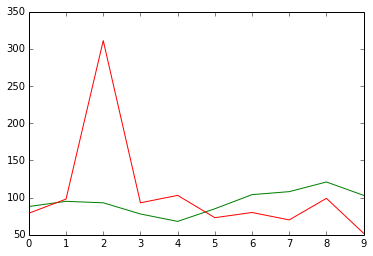

In [44]:
#ploteando el vector distancia entre cada uno de los puntos del recorrido y el punto final Central
%matplotlib inline
eje_y_20150817 = df_cent_Albo_20150817['Travel_Time']
eje_y_20150727 = df_cent_Albo_20150727['Travel_Time']
plt.plot(eje_y_20150817, color = 'g')
plt.plot(eje_y_20150727, color = 'r')

plt.show()

In [67]:
#convirtiendo la columna timestamp en tipo datetime
#set_of_times = sorted_dist_to_final_317_C41405['timestamp']
set_of_times = sorted_vector_dist_to_final_point_C41405['timestamp']

mytimestamp_list = []
for i in range(0, len(sorted_vector_dist_to_final_point_C41405)-1):
    #ddist = set_of_points[i+1]-set_of_points[i]

    #time1 = datetime.datetime.strptime(set_of_times[i+1], "%d-%m-%Y %H:%M:%S")
    time0 = datetime.datetime.strptime(set_of_times[i], "%d-%m-%Y %H:%M:%S")
    #dtime = (time1-time0).total_seconds()/60
    #gradient = ddist/dtime
    mytimestamp_list.insert (len(mytimestamp_list), time0)
#convertir la lista "mytimestamp_list" a dataframe
df_mytimestamp_list = pd.DataFrame(mytimestamp_list, columns=['timestamp'])


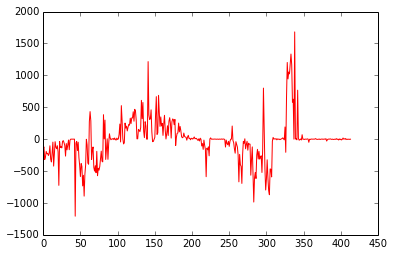

In [69]:

#calcular el gradiente(pendiente) = 0 para saber los conjuntos de maximos y minimos
set_of_points = sorted_vector_dist_to_final_point_C41405['distance']
set_of_times = sorted_vector_dist_to_final_point_C41405['timestamp']

gradient_list = []
gradient_matrix = [] #matriz que tiene 4 columnas tiempo1, tiempo2,distancia1, distancia2, pendiente 
#con los que se calcula la pendiente
for i in range(0, len(sorted_vector_dist_to_final_point_C41405)-2):
    ddist = set_of_points[i+1]-set_of_points[i]

    time1 = datetime.datetime.strptime(set_of_times[i+1], "%d-%m-%Y %H:%M:%S")
    time0 = datetime.datetime.strptime(set_of_times[i], "%d-%m-%Y %H:%M:%S")
    dtime = (time1-time0).total_seconds()/60
    gradient = ddist/dtime
    gradient_list.insert (len(gradient_list), gradient)
    gradient_matrix.insert (len(gradient_matrix), [set_of_points[i], set_of_points[i+1],time0, time1, gradient ]) 
    df_gradient_matrix = pd.DataFrame(gradient_matrix, columns=['d1','d2','t1', 't2', 'pendiente'])

%matplotlib inline

plt.plot(gradient_list, color = 'r')

plt.show()    


In [83]:
stop_df_gradient_matrix = df_gradient_matrix[(df_gradient_matrix["pendiente"]==0)]
stop_df_gradient_matrix
df_gradient_matrix

import xlsxwriter
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('20150817_317_C41405.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df_gradient_matrix.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()





In [32]:
df_mytimestamp_list
set_of_points = sorted_dist_to_final_317_C41405['distance']

In [30]:
from IPython.display import IFrame
from IPython.core.display import display
# Google Maps URL template for an iframe
google_maps_url = "http://maps.google.com/maps?q={0}+{1}&" + \
"ie=UTF8&t=h&z={2}&{0},{1}&output=embed".format(-22.9049,-43.1917,14)
display(IFrame(google_maps_url, '425px', '350px'))
